<a href="https://colab.research.google.com/github/Nianguang-Zhao/options-stocks-EM/blob/main/options_stock_expected_move.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/var/folders/lz/xdrxf_vj0pg99cxcb_ph5g680000gn/T/ipykernel_21849/161116224.py:139: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper left')


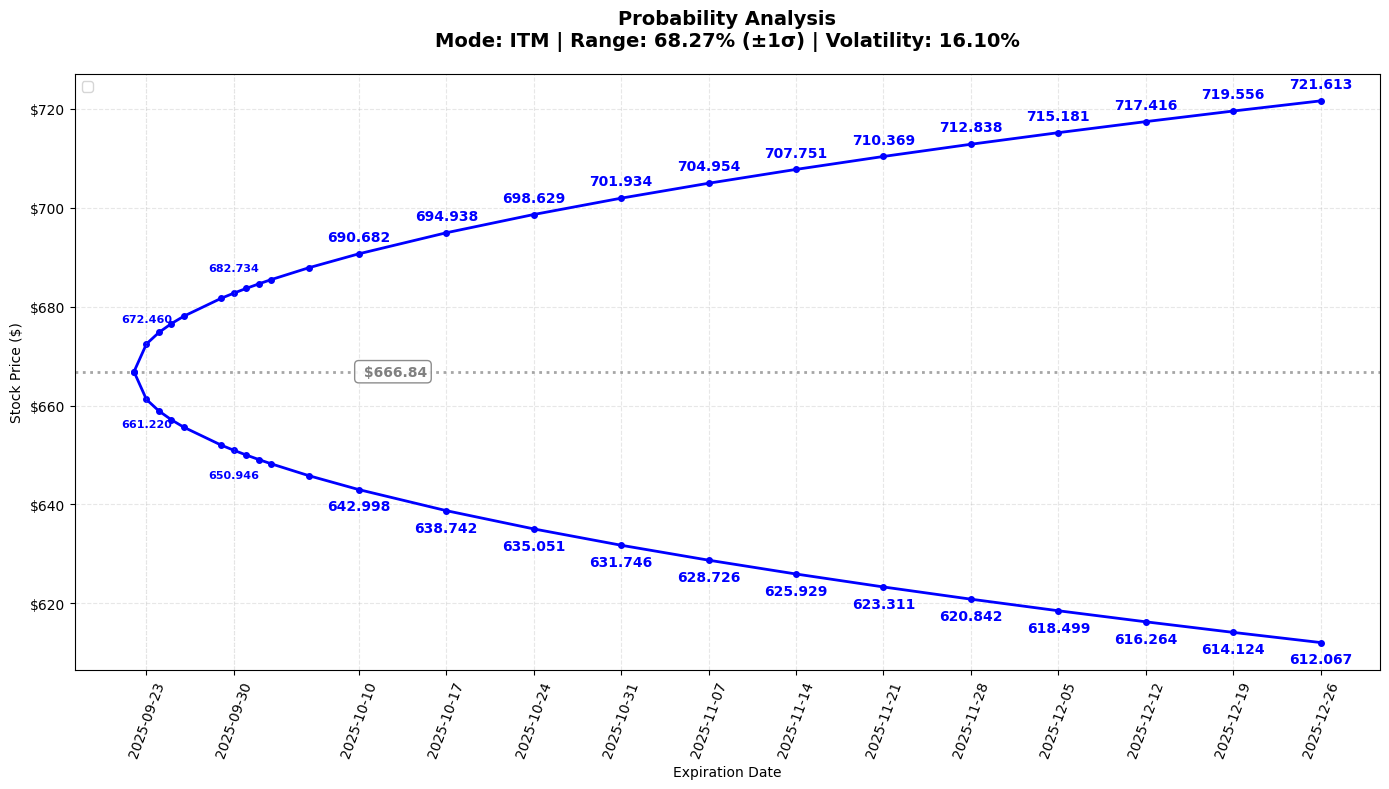

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
from scipy.stats import norm
import yfinance as yf

# ==== Parameters ====
today = dt.date.today()
spy_ticker = yf.Ticker("SPY")
stock_price = spy_ticker.info['regularMarketPrice']

vix_ticker = yf.Ticker("^VIX")
iv = vix_ticker.info['regularMarketPrice']/100

std = 1
risk_free_rate = 0.041

# ==== Generate Trading Days (excluding weekends) ====
def get_next_trading_day(date, days_ahead):
    """Get the next trading day (excluding weekends)"""
    current_date = date
    trading_days = 0

    while trading_days < days_ahead:
        current_date += dt.timedelta(days=1)
        # Skip weekends (Saturday=5, Sunday=6)
        if current_date.weekday() < 5:  # Monday=0, Friday=4
            trading_days += 1

    return current_date

def get_trading_days_list(start_date, num_days):
    """Get a list of the next N trading days"""
    trading_days = []
    current_date = start_date

    for i in range(num_days):
        next_trading_day = get_next_trading_day(current_date, 1)
        trading_days.append(next_trading_day)
        current_date = next_trading_day

    return trading_days

# ==== Get Daily Moves for First 10 Trading Days ====
daily_dates = get_trading_days_list(today, 10)
daily_df = pd.DataFrame({"expiration_day": daily_dates})
daily_df["expiration_day"] = pd.to_datetime(daily_df["expiration_day"])
daily_df["DTE"] = (daily_df["expiration_day"] - pd.to_datetime(today)).dt.days
daily_df["expected_move"] = stock_price * iv * std * (daily_df["DTE"] / 365) ** 0.5
daily_df["upper"] = stock_price + daily_df["expected_move"]
daily_df["lower"] = stock_price - daily_df["expected_move"]
daily_df["type"] = "Daily"

# ==== Generate Weekly Expirations (Fridays) after 10th trading day ====
# Find the date after the 10th trading day
start_weekly = daily_dates[-1] + dt.timedelta(days=1)

# Find the next Friday after that date
days_until_friday = (4 - start_weekly.weekday()) % 7
if days_until_friday == 0:  # If it's already Friday, get next Friday
    days_until_friday = 7
next_friday = start_weekly + dt.timedelta(days=days_until_friday)

# Generate Fridays until end of 2025
end_date = dt.date(2025, 12, 31)
fridays = pd.date_range(next_friday, end_date, freq="W-FRI").date

weekly_df = pd.DataFrame({"expiration_day": fridays})
weekly_df["expiration_day"] = pd.to_datetime(weekly_df["expiration_day"])
weekly_df["DTE"] = (weekly_df["expiration_day"] - pd.to_datetime(today)).dt.days
weekly_df["expected_move"] = stock_price * iv * std * (weekly_df["DTE"] / 365) ** 0.5
weekly_df["upper"] = stock_price + weekly_df["expected_move"]
weekly_df["lower"] = stock_price - weekly_df["expected_move"]
weekly_df["type"] = "Weekly"

# ==== Combine DataFrames ====
today_row = pd.DataFrame({
    "expiration_day": [pd.to_datetime(today)],
    "DTE": [0],
    "expected_move": [0],
    "upper": [stock_price],
    "lower": [stock_price],
    "type": ["Today"]
})

df = pd.concat([today_row, daily_df, weekly_df], ignore_index=True)
plt.figure(figsize=(14, 8))

# Add current price horizontal line (dotted)
plt.axhline(stock_price, color="gray", linestyle=":", linewidth=2, alpha=0.7)

# Plot the probability cone
plt.plot(df["expiration_day"], df["upper"], marker="o", markersize=4, color="blue", linewidth=2)
plt.plot(df["expiration_day"], df["lower"], marker="o", markersize=4, color="blue", linewidth=2)

# Add price labels - daily options (show every other two for clarity)
daily_mask = df["type"] == "Daily"
daily_count = 0
for i, row in df[daily_mask].iterrows():
    if i > 0:  # Skip today's point
        # Only show labels for every other two daily options (0, 3, 6, 9...)
        if daily_count % 5 == 0:
            # Add more space between labels and lines
            offset = 4  # Increase spacing

            # Upper label above, lower label below
            plt.text(row["expiration_day"], row["upper"] + offset, f"{row['upper']:.3f}",
                        ha="center", va="bottom", fontsize=8, color="blue", fontweight='bold')
            plt.text(row["expiration_day"], row["lower"] - offset, f"{row['lower']:.3f}",
                        ha="center", va="top", fontsize=8, color="blue", fontweight='bold')
        daily_count += 1

# Add price labels - weekly options (with more spacing)
weekly_mask = df["type"] == "Weekly"
for i, row in df[weekly_mask].iterrows():
    offset = 2  # Add spacing from the lines
    plt.text(row["expiration_day"], row["upper"] + offset, f"{row['upper']:.3f}",
             ha="center", va="bottom", fontsize=10, color="blue", fontweight='bold')
    plt.text(row["expiration_day"], row["lower"] - offset, f"{row['lower']:.3f}",
             ha="center", va="top", fontsize=10, color="blue", fontweight='bold')

    # Add vertical dotted lines for some daily options (every 3rd)
daily_with_lines = df[daily_mask].iloc[::5]  # Every 3rd daily option
for i, row in daily_with_lines.iterrows():
    if i > 0:  # Skip today's point
        plt.axvline(row["expiration_day"], color="lightgray", linestyle=":", alpha=0.3, linewidth=0.8)

# Add current price label on the dotted line
plt.text(df["expiration_day"].iloc[len(df)//2], stock_price, f' ${stock_price}',
         va='center', ha='left', fontsize=10, fontweight='bold', color='gray',
         bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray', alpha=0.9))

# ==== Chart Formatting ====
plt.title(f"Probability Analysis\nMode: ITM | Range: 68.27% (±1σ) | Volatility: {iv*100:.2f}%",
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel("Expiration Date")
plt.ylabel("Stock Price ($)")
plt.legend(loc='upper left')
plt.grid(True, linestyle="--", alpha=0.3)
plt.xticks(rotation=45)

# Format y-axis
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:.0f}'))

# Set custom x-axis ticks to show selected dates (mix of daily and weekly)
selected_daily = df[df["type"] == "Daily"].iloc[::5]  # Every 3rd daily
weekly_dates = df[df["type"] == "Weekly"].iloc[::1]   # Every 2nd weekly for less crowding
all_selected_dates = list(selected_daily["expiration_day"]) + list(weekly_dates["expiration_day"])
all_selected_dates = sorted(all_selected_dates)  # Sort chronologically
plt.xticks(all_selected_dates, rotation=70)
plt.tight_layout()
plt.show()

In [4]:
sample_df = df[['expiration_day', 'DTE', 'lower', 'upper', 'expected_move', 'type']]
sample_df['expiration_day'] = sample_df['expiration_day'].dt.strftime('%b %d')

# Format the columns to 3 decimal places
sample_df['lower'] = sample_df['lower'].round(3)
sample_df['upper'] = sample_df['upper'].round(3)
sample_df['expected move'] = sample_df['expected_move'].round(3)

# Select only the required columns for the revised table
revised_df = sample_df[sample_df['DTE']>0][['expiration_day', 'DTE', 'lower', 'upper','expected move']].copy()

# Combine expiration day and DTE for column names
revised_df['Expiration'] = revised_df['expiration_day'] + ' (' + revised_df['DTE'].astype(str) + 'D)'

# Set 'expiration_day_with_DTE' as index and transpose
revised_df = revised_df.set_index('Expiration')[['lower', 'upper','expected move']].T

display(revised_df)

Expiration,Sep 23 (1D),Sep 24 (2D),Sep 25 (3D),Sep 26 (4D),Sep 29 (7D),Sep 30 (8D),Oct 01 (9D),Oct 02 (10D),Oct 03 (11D),Oct 06 (14D),...,Oct 24 (32D),Oct 31 (39D),Nov 07 (46D),Nov 14 (53D),Nov 21 (60D),Nov 28 (67D),Dec 05 (74D),Dec 12 (81D),Dec 19 (88D),Dec 26 (95D)
lower,661.22,658.893,657.107,655.601,651.972,650.946,649.981,649.069,648.202,645.814,...,635.051,631.746,628.726,625.929,623.311,620.842,618.499,616.264,614.124,612.067
upper,672.46,674.787,676.573,678.079,681.708,682.734,683.699,684.611,685.478,687.866,...,698.629,701.934,704.954,707.751,710.369,712.838,715.181,717.416,719.556,721.613
expected move,5.62,7.947,9.733,11.239,14.868,15.894,16.859,17.771,18.638,21.026,...,31.789,35.094,38.114,40.911,43.529,45.998,48.341,50.576,52.716,54.773


In [5]:
###### calculate deltas ######

current_price_rounded = round(stock_price)
strike_range = 15
strike_prices = list(range(current_price_rounded - strike_range,
                          current_price_rounded + strike_range + 1))

# Get daily dates for first 10 trading days
daily_dates = get_trading_days_list(today, 10)

# Get weekly dates (Fridays) after 10th trading day
start_weekly = daily_dates[-1] + dt.timedelta(days=1)
days_until_friday = (4 - start_weekly.weekday()) % 7
if days_until_friday == 0:
    days_until_friday = 7
next_friday = start_weekly + dt.timedelta(days=days_until_friday)
end_date = dt.date(2025, 12, 31)
fridays = pd.date_range(next_friday, end_date, freq="W-FRI").date

# Combine all expiration dates
all_expiration_dates = daily_dates + list(fridays)

def calculate_call_delta(S, K, T, r, sigma):
    if T <= 0:
        return 1.0 if S > K else 0.0

    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    delta = norm.cdf(d1)
    return delta

# ==== Calculate Call Deltas and Create 2D Table ====
delta_table_data = {}

for exp_date in all_expiration_dates:
    dte = (exp_date - today).days
    time_to_exp = dte / 365.0

    # Create row for this expiration date
    row_data = {}

    for strike in strike_prices:
        # Calculate call delta
        call_delta = calculate_call_delta(stock_price, strike, time_to_exp, risk_free_rate, iv)
        row_data[strike] = call_delta

    # Use date as row index
    delta_table_data[exp_date] = row_data

# Create 2D DataFrame (dates as rows, strikes as columns)
delta_2d_df = pd.DataFrame.from_dict(delta_table_data, orient='index')
delta_2d_df.index = pd.to_datetime(delta_2d_df.index)
delta_2d_df = delta_2d_df.sort_index()

# ==== Display the 2D Table ====
# Format the display - show first 15 rows with all strikes
display_df = delta_2d_df.head(15).copy()
display_df.index = display_df.index.strftime('%Y-%m-%d')
display_df = display_df.round(4)
#display_df


In [6]:
# Interactive Plotly Chart - Based on Your Existing Chart
import plotly.graph_objects as go

# ==== Create Interactive Plotly Chart ====
fig = go.Figure()

# Add probability cone (upper and lower bounds) - exact same as your original
fig.add_trace(go.Scatter(
    x=df['expiration_day'],
    y=df['upper'],
    mode='lines+markers',
    name='',  # No legend name to match your original
    line=dict(color='blue', width=2),
    marker=dict(size=4, color='blue'),
    showlegend=False,
    hoverinfo='skip'  # Skip hover for cone lines
))

fig.add_trace(go.Scatter(
    x=df['expiration_day'],
    y=df['lower'],
    mode='lines+markers',
    name='',  # No legend name to match your original
    line=dict(color='blue', width=2),
    marker=dict(size=4, color='blue'),
    fill='tonexty',
    fillcolor='rgba(0,100,200,0.1)',
    showlegend=False,
    hoverinfo='skip'  # Skip hover for cone lines
))

# Add current price line (gray dotted) with stock price in middle
fig.add_trace(go.Scatter(
    x=[df['expiration_day'].min(), df['expiration_day'].max()],
    y=[stock_price, stock_price],
    mode='lines',
    line=dict(color='gray', width=2, dash='dot'),
    showlegend=False,
    hoverinfo='skip',
    name='Current Price Line'
))

# Add current stock price label in the middle of the chart
fig.add_annotation(
    x=df["expiration_day"].iloc[len(df)//2],  # Middle of the date range
    y=stock_price,
    text=f'Current Price:  ${stock_price}',
    showarrow=False,
    font=dict(size=10, color='gray', family="Arial Black"),
    bgcolor='white',
    bordercolor='gray',
    borderwidth=1,
    xanchor='left',
    yanchor='middle'
)

# Add price labels on the cone lines - replicate your original labels
daily_mask = df["type"] == "Daily"
daily_count = 0
annotations = []

for i, row in df[daily_mask].iterrows():
    if i > 0:  # Skip today's point
        if daily_count % 5 == 0:  # Show every 5th daily option
            # Upper label
            annotations.append(dict(
                x=row["expiration_day"],
                y=row["upper"] + 4,
                text=f"{row['upper']:.3f}",
                showarrow=False,
                font=dict(size=8, color="blue", family="Arial Black"),
                xanchor="center",
                yanchor="bottom"
            ))
            # Lower label
            annotations.append(dict(
                x=row["expiration_day"],
                y=row["lower"] - 4,
                text=f"{row['lower']:.3f}",
                showarrow=False,
                font=dict(size=8, color="blue", family="Arial Black"),
                xanchor="center",
                yanchor="top"
            ))
        daily_count += 1

# Add price labels for weekly options
weekly_mask = df["type"] == "Weekly"
for i, row in df[weekly_mask].iterrows():
    # Upper label
    annotations.append(dict(
        x=row["expiration_day"],
        y=row["upper"] + 2,
        text=f"{row['upper']:.3f}",
        showarrow=False,
        font=dict(size=10, color="blue", family="Arial Black"),
        xanchor="center",
        yanchor="bottom"
    ))
    # Lower label
    annotations.append(dict(
        x=row["expiration_day"],
        y=row["lower"] - 2,
        text=f"{row['lower']:.3f}",
        showarrow=False,
        font=dict(size=10, color="blue", family="Arial Black"),
        xanchor="center",
        yanchor="top"
    ))

# ==== Add Invisible Hover Layer for Probabilities ====
hover_data = []

# Use your existing delta_2d_df data
for exp_date, row in delta_2d_df.iterrows():
    for strike_price, probability in row.items():
        hover_data.append({
            'expiration_date': exp_date,
            'strike_price': strike_price,
            'probability': probability
        })

hover_df = pd.DataFrame(hover_data)

# Add invisible scatter plot for hover functionality with crosshairs
fig.add_trace(go.Scatter(
    x=hover_df['expiration_date'],
    y=hover_df['strike_price'],
    mode='markers',
    marker=dict(
        size=8,
        color='rgba(0,0,0,0)',  # Completely transparent
        line=dict(width=0)
    ),
    showlegend=False,
    hovertemplate='<b>Strike Price: $%{y}</b><br>' +
                  'Expiration: %{x|%b %d}<br>' +
                  'Probability Above: %{customdata:.1%}<br>' +
                  '<extra></extra>',
    customdata=hover_df['probability'],
    name='Probabilities'
))

# Update layout to match your exact original chart
selected_daily = df[df["type"] == "Daily"].iloc[::5]  # Every 5th daily
weekly_dates = df[df["type"] == "Weekly"].iloc[::1]   # All weekly
all_selected_dates = list(selected_daily["expiration_day"]) + list(weekly_dates["expiration_day"])
all_selected_dates = sorted(all_selected_dates)

fig.update_layout(
    title=dict(
        text=f"Probability Analysis<br>Mode: ITM | Range: 68.27% (±1σ) | Volatility: {iv*100:.2f}%",
        x=0.5,
        font=dict(size=14, family="Arial Black")
    ),
    xaxis_title='Expiration Date',
    yaxis_title='Stock Price ($)',
    hovermode='closest',
    width=1400,
    height=700,
    showlegend=False,  # No legend like your original
    plot_bgcolor='white',
    annotations=annotations,  # Add all the price labels
    # Add box around the plot area
    shapes=[
        dict(
            type="rect",
            xref="paper", yref="paper",
            x0=0, y0=0, x1=1, y1=1,
            line=dict(color="black", width=1),
            fillcolor="rgba(0,0,0,0)"
        )
    ],
    xaxis=dict(
        tickvals=all_selected_dates,
        ticktext=[d.strftime('%Y-%m-%d') for d in all_selected_dates],
        tickangle=70,
        gridcolor='lightgray',
        gridwidth=1,
        linecolor='black',
        linewidth=1,
        mirror=True  # Add border
    ),
    yaxis=dict(
        tickformat='$,.0f',
        gridcolor='lightgray',
        gridwidth=1,
        linecolor='black',
        linewidth=1,
        mirror=True  # Add border
    ),
    # Add crosshair cursor
    hoverlabel=dict(
        bgcolor="white",
        bordercolor="black",
        font_size=12
    )
)

# Add crosshair lines (vertical and horizontal dotted gray lines on hover)
fig.update_layout(
    xaxis=dict(
        showspikes=True,
        spikecolor="gray",
        spikethickness=1,
        spikedash="dot",
        spikemode="across",
        tickvals=all_selected_dates,
        ticktext=[d.strftime('%Y-%m-%d') for d in all_selected_dates],
        tickangle=70,
        gridcolor='lightgray',
        gridwidth=1
    ),
    yaxis=dict(
        showspikes=True,
        spikecolor="gray",
        spikethickness=1,
        spikedash="dot",
        spikemode="across",
        tickformat='$,.0f',
        gridcolor='lightgray',
        gridwidth=1
    )
)

fig.show()

print("Hover over any point on the chart to see probability of expiring above that strike price!")

Hover over any point on the chart to see probability of expiring above that strike price!
